In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import gym

from models import *

## Help functions

In [2]:
def train(env, t_model, total_steps, n_rollouts, tseed, version='v1'):
    np.random.seed(tseed)
    try:
        observation = env.reset(seed=tseed)
    except:
        env.seed(tseed)
        observation = env.reset()
        
    for step in tqdm(range(total_steps)):
        for ro in range(n_rollouts):
            pos_action, neg_action, noise = t_model.get_actions(observation, is_train=True)
            
            pos_observation, pos_reward, pos_done, pos_info = env.step(pos_action)
            neg_observation, neg_reward, neg_done, neg_info = env.step(neg_action)
            
            t_model.remember([pos_action[0], neg_action[0], noise[0], pos_reward, neg_reward])
            
            if version == 'v2':
                t_model.states += pos_observation, neg_observation
                
        # select next state
        action = t_model.get_actions(observation)
        observation, _, done, _ = env.step(action)

        if (pos_done or neg_done):
            observation = env.reset()
            
        t_model.learn()

    env.close()
    return t_model

In [3]:
def evaluate(env, model, eval_steps, eseed):
    np.random.seed(eseed)
    try:
        observation = env.reset(seed=eseed)
    except:
        env.seed(eseed)
        observation = env.reset()
        
    score = 0

    for step in range(eval_steps):
        action = model.get_actions(observation)
        observation, reward, done, info = env.step(action)

        score += reward

        if done:
            observation = env.reset()

    env.close()
    return score

# Ablation study / models testing

In [4]:
# Random seed
SEED = 42
# number of training steps
TOTAL_STEPS = 10000
# Number of rollouts over one state 
N_ROLLOUTS = 64
# How many samples use to do partial buffer update
N_SAMPLES_UPDATE = 4
# Number of evaluation steps
EVAL_STEPS = 1000

# exploration noise std, for normal distribution
STD = 0.1
# LR for ARS update
ALPHA = 2e-2 

env_id = 0
envs = ['Pendulum-v1']

np.random.seed(SEED)
RANDOM_EVAL_SEEDS = np.random.randint(100000, size=EVAL_STEPS)

env = gym.make(envs[env_id])

n_action = env.action_space.shape[0]
n_state = env.observation_space.shape[0]
# print(n_action, n_state)

state_high = env.observation_space.high
state_low = env.observation_space.low

## BRS_1

In [5]:
model = BaseRandomSearch(n_state, n_action, std=STD)

trained_model = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED)

BRS_1_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model, EVAL_STEPS, int(eseed))
    BRS_1_rewards += [score]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

## BRS_1_RS

In [6]:
model = BRS_RS(n_state, n_action, std=STD, n_samples=N_SAMPLES_UPDATE)

trained_model = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED)

BRS_1_RS_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model, EVAL_STEPS, int(eseed))
    BRS_1_RS_rewards += [score]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

## BRS_1_SS

In [7]:
model = BRS_SS(n_state, n_action, std=STD, n_samples=N_SAMPLES_UPDATE)

trained_model = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED)

BRS_1_SS_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model, EVAL_STEPS, int(eseed))
    BRS_1_SS_rewards += [score]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

## BRS_1_SSn

In [8]:
model = BRS_SSn(n_state, n_action, std=STD, n_samples=N_SAMPLES_UPDATE, 
               state_low=state_low, state_high=state_high)

trained_model = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED)

BRS_1_SSn_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model, EVAL_STEPS, int(eseed))
    BRS_1_SSn_rewards += [score]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

## BRS_2

In [9]:
model = BaseRandomSearch_v2(n_state, n_action, std=STD)

trained_model = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED, version='v2')

BRS_2_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model, EVAL_STEPS, int(eseed))
    BRS_2_rewards += [score]

  0%|          | 0/10000 [00:00<?, ?it/s]

/home/ivan/Projects/RL_final/ARS_RL/models.py:27: RuntimeWarning: invalid value encountered in sqrt
  self.std = np.sqrt(self.sum2/self.n - self.sum1*self.sum1/self.n/self.n)


  0%|          | 0/1000 [00:00<?, ?it/s]

## BRS_2_RS

In [10]:
model = BRS_v2_RS(n_state, n_action, std=STD, n_samples=N_SAMPLES_UPDATE)

trained_model = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED, version='v2')

BRS_2_RS_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model, EVAL_STEPS, int(eseed))
    BRS_2_RS_rewards += [score]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

## BRS_2_SS

In [11]:
model = BRS_v2_SS(n_state, n_action, std=STD, n_samples=N_SAMPLES_UPDATE)

trained_model = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED, version='v2')

BRS_2_SS_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model, EVAL_STEPS, int(eseed))
    BRS_2_SS_rewards += [score]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

## BRS_2_SSn

In [12]:
model = BRS_v2_SSn(n_state, n_action, std=STD, n_samples=N_SAMPLES_UPDATE,
                   state_low=state_low, state_high=state_high)

trained_model = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED, version='v2')

BRS_2_SSn_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model, EVAL_STEPS, int(eseed))
    BRS_2_SSn_rewards += [score]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

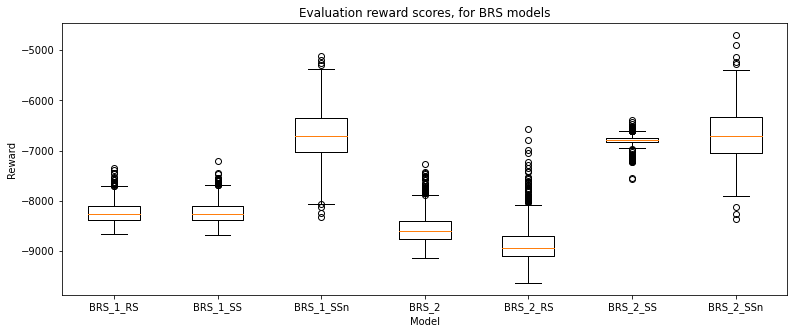

In [13]:
brs_data = [BRS_1_rewards, BRS_1_RS_rewards, BRS_1_SS_rewards, BRS_1_SSn_rewards,
     BRS_2_rewards, BRS_2_RS_rewards, BRS_2_SS_rewards, BRS_2_SSn_rewards]
brs_labels = ['BRS_1', 'BRS_1_RS', 'BRS_1_SS', 'BRS_1_SSn',
          'BRS_2', 'BRS_2_RS', 'BRS_2_SS', 'BRS_2_SSn']

fig, ax = plt.subplots(figsize=(13,5))
b = ax.boxplot(brs_data)

ax.set_xlabel('Model')
ax.set_ylabel('Reward')
ax.set_title('Evaluation reward scores, for BRS models')

ax.set_xticklabels(brs_labels)

plt.show()


## ARS_1

In [14]:
model = ARS_v1(n_state, n_action, std=STD, alpha=ALPHA)

trained_model_ars1 = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED, version='v1')

ARS_1_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model_ars1, EVAL_STEPS, int(eseed))
    ARS_1_rewards += [score]


  0%|          | 0/10000 [00:00<?, ?it/s]

/home/ivan/Projects/RL_final/ARS_RL/models.py:343: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  b_buffer = np.array(self.buffer)


  0%|          | 0/1000 [00:00<?, ?it/s]

## ARS_1_RS

In [ ]:
model = ARS_v1_RS(n_state, n_action, std=STD, n_samples=N_SAMPLES_UPDATE, alpha=ALPHA)

trained_model_ars1rs = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED, version='v1')

ARS_1_RS_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model_ars1rs, EVAL_STEPS, int(eseed))
    ARS_1_RS_rewards += [score]


  0%|          | 0/10000 [00:00<?, ?it/s]

## ARS_1_SS

In [ ]:
model = ARS_v1_SS(n_state, n_action, std=STD, n_samples=N_SAMPLES_UPDATE, alpha=ALPHA)

trained_model_ars1ss = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED, version='v1')

ARS_1_SS_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model_ars1ss, EVAL_STEPS, int(eseed))
    ARS_1_SS_rewards += [score]


## ARS_1_SSn

In [ ]:
model = ARS_v1_SSn(n_state, n_action, std=STD, n_samples=N_SAMPLES_UPDATE, alpha=ALPHA,
                   state_low=state_low, state_high=state_high)

trained_model_ars1ssn = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED, version='v1')

ARS_1_SSn_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model_ars1ssn, EVAL_STEPS, int(eseed))
    ARS_1_SSn_rewards += [score]


## ARS_2

In [ ]:

model = ARS_v2(n_state, n_action, std=STD, alpha=ALPHA)

trained_model_ars2 = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED, version='v2')

ARS_2_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model_ars2, EVAL_STEPS, int(eseed))
    ARS_2_rewards += [score]


## ARS_2_RS

In [ ]:
model = ARS_v2_RS(n_state, n_action, std=STD, n_samples=N_SAMPLES_UPDATE, alpha=ALPHA)

trained_model_ars2rs = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED, version='v2')

ARS_2_RS_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model_ars2rs, EVAL_STEPS, int(eseed))
    ARS_2_RS_rewards += [score]


## ARS_2_SS 

In [ ]:
model = ARS_v2_SS(n_state, n_action, std=STD, n_samples=N_SAMPLES_UPDATE, alpha=ALPHA)

trained_model_ars2ss = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED, version='v2')

ARS_2_SS_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model_ars2ss, EVAL_STEPS, int(eseed))
    ARS_2_SS_rewards += [score]


## ARS_2_SSn

In [ ]:
model = ARS_v2_SSn(n_state, n_action, std=STD, n_samples=N_SAMPLES_UPDATE, alpha=ALPHA,
                  state_low=state_low, state_high=state_high)

trained_model_ars2ssn = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED, version='v2')

ARS_2_SSn_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model_ars2ssn, EVAL_STEPS, int(eseed))
    ARS_2_SSn_rewards += [score]


In [ ]:
ars_data = [ARS_1_rewards, ARS_1_RS_rewards, ARS_1_SS_rewards, ARS_1_SSn_rewards,
     ARS_2_rewards, ARS_2_RS_rewards, ARS_2_SS_rewards, ARS_2_SSn_rewards]
ars_labels = ['ARS_1', 'ARS_1_RS', 'ARS_1_SS', 'ARS_1_SSn',
          'ARS_2', 'ARS_2_RS', 'ARS_2_SS', 'ARS_2_SSn']

fig, ax = plt.subplots(figsize=(13,5))
b = ax.boxplot(ars_data)

ax.set_xlabel('Model')
ax.set_ylabel('Reward')
ax.set_title('Evaluation reward scores, for ARS models')

ax.set_xticklabels(ars_labels)

plt.show()


In [ ]:
model_list = [trained_model_ars1, trained_model_ars1rs, trained_model_ars1ss, trained_model_ars1ssn,
              trained_model_ars2, trained_model_ars2rs, trained_model_ars2ss, trained_model_ars2ssn]

R = []

for i, model in enumerate(model_list):
    R += [model.std_rewards_over_training]


fig, ax = plt.subplots(figsize=(13,5))
b = ax.boxplot(R)
ax.set_xticklabels(ars_labels)
    
ax.set_title('Variance of the rewards used for update')
plt.show()

In [ ]:
D = brs_data + ars_data
labels = brs_labels + ars_labels

fig, ax = plt.subplots(figsize=(16,5))
b = ax.boxplot(D)

ax.set_xlabel('Model')
ax.set_ylabel('Reward')
ax.set_title('Evaluation reward scores, for tested models')

ax.set_xticklabels(labels)
plt.xticks(rotation = 45)

plt.show()
